In [29]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [50]:
root_path = 'data'
img_files = os.listdir(root_path)
img_files

['coursera.jpg', 'soren_1.jpg']

In [31]:
class Context:
    '''
    Clase que permite almacenar el contexto de ejecución de los pasos 
    del pipeline. Esta clase será particularmente útil en el último 
    paso del pipeline donde necesitaremoslos datos generados por todos 
    los pasos del pipeline para imprimir el detalle de los resultados.
    '''
    def __init__(self, model) -> None:
        self.model = model

In [32]:
class ImageLoader(BaseEstimator, TransformerMixin) :
    '''
    Este paso del pipeline se encarga de cargar la imagen a partir de un 
    archivo. En este paso se recibe un archivo y se retorna una matriz 
    de pixeles en formato RGB. 
    '''
    def __init__(self, context) -> None:
        self.context = context

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        '''
        Recibe un archivo en el parámetro X y retorna una matriz de 
        pixeles en formato RGB como resultado de la transformación. 
        '''
        img = cv2.imread(os.path.join(root_path, X))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.context.original_image = img
        return img

In [33]:
class ImageProcessor(BaseEstimator, TransformerMixin) :
    '''
    Este paso del pipeline se encarga de hacer el pre-procesamiento 
    necesario para el entrenamiento del modelo. Concretamente, 
    en este paso se recibe una imagen como una matriz de pixeles 
    en RGB se retorna un arreglo de números. El arreglo esta normalizado. 
    '''
    def __init__(self, context) -> None:
        self.context = context

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        '''
        Recibe una matriz de pixeles RGB en el parámetro X y retorna un 
        arreglo de tres dimensiones normalizado al rango [0, 1]. 
        '''
        img = X.reshape((-1, 3))
        img = img / 255.0
        self.context.normalized_image = img
        return img

In [43]:
class Model(BaseEstimator, TransformerMixin) :
    
    def __init__(self, clusterer) -> None:
        self.clusterer = clusterer

    def fit(self, X, y=None):
        return self.clusterer.fit(X, y)
    
    def transform(self, X):
        return X

num_clusters = 5

# Inicialización del modelo de kmeans para la segmentación.
kmeans = KMeans(max_iter=200, n_init=10, n_clusters=num_clusters)

# Inicialización del modelo de DBSCAN para la segmentación.
radius = 0.3
dbscan = DBSCAN(metric="manhattan", eps=radius)

# Inicialización del modelo de AgglomerativeClustering para la segmentación.
agglomerativeClustering = AgglomerativeClustering(n_clusters=None, connectivity=None, linkage='single', distance_threshold=0.9)

In [35]:
class ImageSegmentation(BaseEstimator, TransformerMixin) :
    '''
    En este paso del pipeline, se segmenta la imagen original generando 
    una máscara a partir de los centroides encontrados por el algoritmo.
    '''
    def __init__(self, context) -> None:
        self.context = context

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        labels = self.context.model.clusterer.labels_
        centroids = np.array([[255, 255, 255], [0, 0, 255], [0, 255, 255], [255, 0, 255], [255, 255, 0]])
        img = centroids[labels]
        img = img.reshape(self.context.original_image.shape)
        self.context.segmented_image = img
        return img

In [36]:
class PrettyPrinter(BaseEstimator, TransformerMixin) :
    '''
    Finalmente, queremos imprimir las imagenes original y 
    segmentada así como la paleta de colores formada por los 
    centroides encontrados por k-means. 
    '''
    def __init__(self, context) -> None:
        self.context = context

    def fit(self, X, y=None):
        figsize = len(self.context.original_image) * 0.0021
        plt.figure(figsize=(10, figsize))

        plt.subplot(1, 2, 1)
        plt.title('Imagen original')
        plt.imshow(self.context.original_image)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title('Imagen segmentada')
        plt.imshow(self.context.segmented_image.astype(np.uint8))
        plt.axis('off')

        plt.tight_layout()
        plt.show()
        
        print('----')
        print('')

        return self

/var/folders/90/_hy0cfxn5zd2bhpqjv1zn4ch0000gn/T/ipykernel_80736/867070143.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


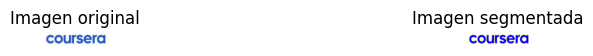

----



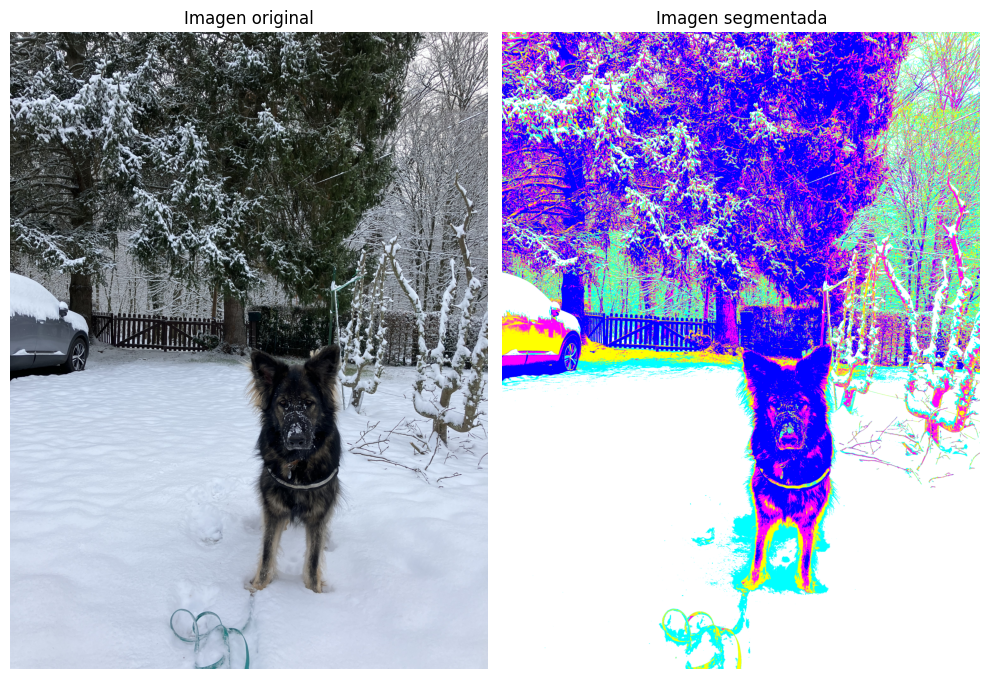

----



In [51]:
model = Model(clusterer=kmeans)
#model = Model(clusterer=agglomerativeClustering)

for i in range(len(img_files)):  
    context = Context(model=model)
    steps = [
        ("loader", ImageLoader(context)),
        ("processor", ImageProcessor(context)),
        ("model", model),
        ("segmentation", ImageSegmentation(context)),
        ("prettyPrinter", PrettyPrinter(context))
    ]
    pipeline = Pipeline(steps)
    pipeline.fit(img_files[i])